In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
from surprise import Reader, Dataset
from surprise.prediction_algorithms.knns import KNNBasic
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [222]:
_PATH = "10-11_Data"
_MOVIE_ID = 'movie_id'
_USER_ID = 'user_id'
_RATING = 'rating'
_TITLE = 'movie_title'
_MAX_RATING = 5

In [223]:
_movies = pd.read_csv(f'{_PATH}/movie_profiles.csv', sep='|', error_bad_lines=False)
_ratings = pd.read_csv(f'{_PATH}/ratings.csv', sep='\t', error_bad_lines=False)

_movies.drop([' release date ', ' video release date ', 'IMDb URL '], axis=1, inplace=True)
_ratings.drop('timestamp', axis=1, inplace=True)

_movies.rename(columns = {'movie id ': _MOVIE_ID}, inplace = True)
_movies.rename(columns = {' movie title ': _TITLE}, inplace = True)
_ratings.rename(columns = {'movie_id': _MOVIE_ID}, inplace = True)
_ratings.rename(columns = {'user_id' : _USER_ID}, inplace = True)

In [224]:
print(f'Length of movies: {len(_movies)}')
_movies.head()

Length of movies: 1682


,movie_id,movie_title,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [225]:
print(f'Length of ratings: {len(_ratings)}')
print(_ratings["rating"].value_counts())
_ratings.head()

Length of ratings: 100000
4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


# 1. Collaborative Filtering

In [226]:
_movie_pivot = _ratings.pivot(index=_USER_ID, columns=_MOVIE_ID, values=_RATING).reset_index()
_movie_depivot = _movie_pivot.melt(id_vars=_USER_ID,value_name=_RATING)
_movie_train = _ratings
_movie_test = _movie_depivot[_movie_depivot[_RATING].isna()]

In [227]:
_movie_pivot.iloc[:20, :20]

movie_id,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,5.00,3.00,4.00,3.00,3.00,5.00,4.00,1.00,5.00,3.00,2.00,5.00,5.00,5.00,5.00,5.00,3.00,4.00,5.00
1,2,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,4.00,4.00,NaN,NaN,NaN,NaN,3.00
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN
5,6,4.00,NaN,NaN,NaN,NaN,NaN,2.00,4.00,4.00,NaN,NaN,4.00,2.00,5.00,3.00,NaN,NaN,NaN,4.00
6,7,NaN,NaN,NaN,5.00,NaN,NaN,5.00,5.00,5.00,4.00,3.00,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,NaN,NaN,NaN,NaN,NaN,5.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,4.00,NaN,NaN,4.00,NaN,NaN,4.00,NaN,4.00,NaN,4.00,5.00,3.00,NaN,NaN,4.00,NaN,NaN,NaN


In [228]:
_movie_train.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [229]:
_movie_test.head()

,user_id,movie_id,rating
2,3,1,NaN
3,4,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,NaN


In [230]:
# Setting the dataset in surprise format (user_id, item_id, rating)
_reader = Reader(rating_scale=(1, 5))
_trainset_model_surprise = Dataset.load_from_df(_movie_train, _reader).build_full_trainset()
_testset_model_surprise = Dataset.load_from_df(_movie_test, _reader).build_full_trainset().build_testset()

# User-based kNN Regression
_model = KNNBasic(k=3, 
                 sim_options = {"name": "cosine", "user_based": True} # similarity
                 )
predictions = _model.fit(_trainset_model_surprise).test(_testset_model_surprise)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [240]:
result = pd.DataFrame(predictions)[["uid", "iid", "r_ui", "est"]]

In [248]:
_USERS = [26, 50, 101]
for user in _USERS:
    print(f"\n\tUser ID: {user}")
    top_5 = result[result.uid == user].sort_values(by="est", ascending=False).head()
    print(_movies[_movies.movie_id.isin(top_5["iid"])][[_TITLE, _MOVIE_ID]])


	User ID: 26
                                     movie_title  movie_id
21                             Braveheart (1995)        22
479                    North by Northwest (1959)       480
1188                          Prefontaine (1997)      1189
1200  Marlene Dietrich: Shadow and Light (1996)       1201
1499                   Santa with Muscles (1996)      1500

	User ID: 50
                            movie_title  movie_id
735                  Shadowlands (1993)       736
813       Great Day in Harlem, A (1994)       814
918   City of Lost Children, The (1995)       919
1121     They Made Me a Criminal (1939)      1122
1188                 Prefontaine (1997)      1189

	User ID: 101
                                movie_title  movie_id
356   One Flew Over the Cuckoos Nest (1975)       357
897                     Postman, The (1997)       898
1188                     Prefontaine (1997)      1189
1499              Santa with Muscles (1996)      1500
1535                   Aiqing wan

In [232]:
pd.options.display.float_format = "{:,.3f}".format
pd.DataFrame(_model.sim).iloc[:20, :20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000,0.873,0.912,0.971,1.000,0.959,0.943,0.894,0.950,0.919,0.943,0.904,0.930,0.947,0.984,0.962,0.938,0.854,0.954,0.966
1,0.873,1.000,0.848,0.836,0.926,0.932,0.851,0.940,0.859,0.889,0.892,0.854,0.938,0.947,0.956,0.887,0.673,0.915,0.922,0.905
2,0.912,0.848,1.000,0.901,0.862,0.973,0.987,0.960,0.947,0.971,0.951,0.925,0.947,0.973,0.899,0.943,0.980,0.944,0.933,0.933
3,0.971,0.836,0.901,1.000,1.000,0.946,0.931,0.937,0.940,0.951,0.944,0.927,0.945,0.957,0.912,0.957,0.959,0.942,0.948,0.950
4,1.000,0.926,0.862,1.000,1.000,0.822,0.000,0.980,0.878,0.906,0.876,0.971,0.911,0.950,0.932,0.741,0.000,0.997,1.000,0.904
5,0.959,0.932,0.973,0.946,0.822,1.000,0.938,0.971,0.953,0.958,0.956,0.961,0.977,0.975,0.966,0.970,0.968,0.965,0.974,0.956
6,0.943,0.851,0.987,0.931,0.000,0.938,1.000,0.920,0.944,0.962,0.960,0.921,0.931,0.969,0.819,0.956,0.919,0.938,0.954,0.937
7,0.894,0.940,0.960,0.937,0.980,0.971,0.920,1.000,0.940,0.952,0.955,0.959,0.986,0.979,0.961,0.969,0.939,0.951,0.967,0.962
8,0.950,0.859,0.947,0.940,0.878,0.953,0.944,0.940,1.000,0.944,0.923,0.937,0.924,0.958,0.914,0.941,0.937,0.923,0.942,0.939
9,0.919,0.889,0.971,0.951,0.906,0.958,0.962,0.952,0.944,1.000,0.959,0.926,0.954,0.964,0.890,0.960,0.965,0.959,0.957,0.963


# 2. Content-based

In [266]:
_user_feature = _ratings.merge(_movies, on=_MOVIE_ID, how='left')
_user_feature.iloc[:,8:] = _user_feature.iloc[:,8:].mul(_user_feature.iloc[:,2]/_MAX_RATING, axis='index')
_DROP_COL = [_RATING, _TITLE]
_user_feature = _user_feature.drop(_DROP_COL, axis=1).groupby(_USER_ID).mean()

_sim_matrix = cosine_similarity(_user_feature, _movies.drop(_TITLE, axis=1))

_sim_matrix = pd.DataFrame(_sim_matrix, 
                          index=_user_feature.index, 
                          columns=_movies.drop(_TITLE, axis=1).index).reset_index()

result = _sim_matrix.melt(id_vars=_USER_ID, value_name='similarity')\
               .sort_values(by=[_USER_ID,'similarity'], ascending=False)
result

,user_id,variable,similarity
1406012,943,1490,1.00
1467307,943,1555,1.00
1470136,943,1558,1.00
1094822,943,1160,1.00
1160832,943,1230,1.00
...,...,...,...
1886,1,2,0.95
3772,1,4,0.95
2829,1,3,0.92
943,1,1,0.76


In [261]:
_user_feature.iloc[:10, :10]

,movie_id,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama
user_id,,,,,,,,,,
1,136.50,0.00,0.28,0.15,0.04,0.04,0.23,0.06,0.02,0.31
2,249.50,0.00,0.16,0.05,0.02,0.04,0.20,0.11,0.00,0.43
3,318.81,0.00,0.26,0.07,0.00,0.00,0.11,0.11,0.02,0.24
4,291.04,0.00,0.33,0.17,0.00,0.00,0.17,0.16,0.04,0.23
5,291.29,0.01,0.32,0.19,0.08,0.08,0.28,0.04,0.00,0.08
6,312.02,0.00,0.12,0.10,0.05,0.06,0.22,0.05,0.00,0.37
7,392.78,0.00,0.24,0.14,0.03,0.07,0.17,0.06,0.01,0.31
8,301.32,0.00,0.66,0.29,0.00,0.01,0.08,0.13,0.00,0.24
9,370.82,0.00,0.18,0.14,0.00,0.00,0.25,0.00,0.00,0.40


In [273]:
result[result.user_id == 26].head()

,user_id,variable,similarity
1469219,26,1558,1.00
1466390,26,1555,1.00
1405095,26,1490,1.00
1350401,26,1432,1.00
1286277,26,1364,1.00
...,...,...,...
1911,26,2,0.95
3797,26,4,0.95
2854,26,3,0.92
968,26,1,0.76


In [275]:
_USERS = [26, 50, 101]
for user in _USERS:
    print(f"\n\tUser ID: {user}")
    top_5 = result[result.user_id == user].head()
    #print(top_5)
    print(_movies[_movies.movie_id.isin(top_5["variable"])][[_TITLE, _MOVIE_ID]])


	User ID: 26
                                     movie_title  movie_id
1363                         Bird of Prey (1996)      1364
1431                          Mighty, The (1998)      1432
1489                               Fausto (1993)      1490
1554  Secret Adventures of Tom Thumb, The (1993)      1555
1557                            Aparajito (1956)      1558

	User ID: 50
                       movie_title  movie_id
1117            Up in Smoke (1978)      1118
1130                   Safe (1995)      1131
1135  Ghosts of Mississippi (1996)      1136
1158                Stalker (1979)      1159
1171             Women, The (1939)      1172

	User ID: 101
                           movie_title  movie_id
1482  Man in the Iron Mask, The (1998)      1483
1521              Trial by Jury (1994)      1522
1550          Glass Shield, The (1994)      1551
1644           Butcher Boy, The (1998)      1645
1655                Little City (1998)      1656


,user_id,variable,similarity
1469219,26,1558,1.00
1466390,26,1555,1.00
1405095,26,1490,1.00
1350401,26,1432,1.00
1286277,26,1364,1.00
...,...,...,...
1911,26,2,0.95
3797,26,4,0.95
2854,26,3,0.92
968,26,1,0.76


# 3. Model

In [235]:
pd.options.display.float_format = "{:,.2f}".format
user_labels = _movie_pivot.T
user_labels = user_labels.rename(columns=user_labels.iloc[0]).iloc[1:]
user_labels

,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,...,934.00,935.00,936.00,937.00,938.00,939.00,940.00,941.00,942.00,943.00
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.00,4.00,NaN,NaN,4.00,4.00,NaN,NaN,NaN,4.00,...,2.00,3.00,4.00,NaN,4.00,NaN,NaN,5.00,NaN,NaN
2,3.00,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,...,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00
3,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.00,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,4.00,...,5.00,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN
5,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [333]:
_UID = 26

user_labels = _movie_pivot.T
user_labels = user_labels.rename(columns=user_labels.iloc[0]).iloc[1:]
one_user_feature = pd.concat([_ratings, user_labels[_UID]],axis=1)

train_set = one_user_feature.dropna()
test_set = one_user_feature[one_user_feature[_UID].isna()] 

regular_att_train = train_set.drop(_UID, axis=1).values
label_att_train = train_set[_UID].values

regular_att_test = test_set.drop(_UID, axis=1).values
label_att_test = test_set[_UID].values

regressor = DecisionTreeRegressor(
    max_depth=3,
)
regressor.fit(regular_att_train, label_att_train)
prediction = regressor.predict(regular_att_test)
prediction

array([3.09090909, 2.7254902 , 3.09090909, ..., 2.7254902 , 3.38461538,
       3.38461538])

In [334]:
top_5 = pd.DataFrame(prediction).sort_values(by=0).tail(5).index
bad_5 = pd.DataFrame(prediction).sort_values(by=0).head(5).index
print("\tLikes:")
print(_movies[_movies.movie_id.isin(test_set.iloc[top_5][_MOVIE_ID])])
print()
print("\tDislikes:")
print(_movies[_movies.movie_id.isin(test_set.iloc[bad_5][_MOVIE_ID])])


	Likes:
     movie_id              movie_title   unknown    Action    Adventure   \
267       268       Chasing Amy (1997)          0         0            0   
283       284           Tin Cup (1996)          0         0            0   
289       290  Fierce Creatures (1997)          0         0            0   
291       292          Rosewood (1997)          0         0            0   

      Animation   Childrens    Comedy    Crime    Documentary   ...  \
267            0           0         0        0              0  ...   
283            0           0         1        0              0  ...   
289            0           0         1        0              0  ...   
291            0           0         0        0              0  ...   

      Fantasy   Film-Noir    Horror    Musical    Mystery    Romance   \
267          0           0         0          0          0          1   
283          0           0         0          0          0          1   
289          0           0         0

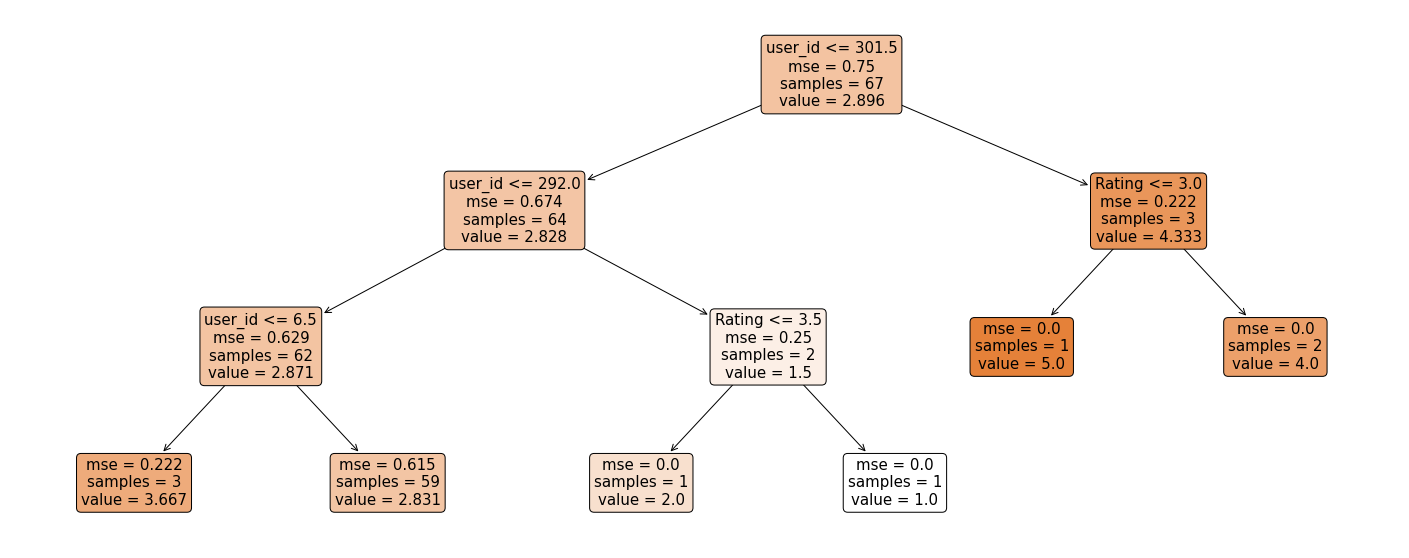

In [325]:
plt.figure(figsize=(25,10))
plot_tree(
        regressor,
        filled = True,
        rounded = True,
        feature_names = [_USER_ID, _MOVIE_ID, "Rating"],
        fontsize = 15
)
print()

AttributeError: 'DecisionTreeRegressor' object has no attribute 'classes_'